# Overview
*Written by Jeremy Manning*

The [HyperTools](https://hypertools.readthedocs.io/en/latest/) Python toolbox provides tools for gaining "geometric insights" into high-dimensional multi-subject datasets.  The overarching idea of the toolbox is to use a series of data processing and visualization approaches to turn a dataset into a 2D or 3D shape or animation that reflects key properties of the original dataset.  This can be a useful way to gain intuitions about a dataset, since our visual systems are adept at identifying complex patterns in visual data.  In this tutorial we will use HyperTools to visualize some neural and behavioral data.


## The HyperTools data visualization pipeline

At its core, the HyperTools toolbox provides a suite of wrappers for myriad functions in the [scikit-learn](https://scikit-learn.org/stable/), [pymvpa](http://www.pymvpa.org/), [braniak](https://brainiak.org/), and [seaborn](https://seaborn.pydata.org/) toolboxes, among others.  A short JMLR paper describing the HyperTools analysis pipeline may be found [here](http://www.jmlr.org/papers/volume18/17-434/17-434.pdf), and a long-form preprint with additional details may be found [here](https://arxiv.org/pdf/1701.08290.pdf).  [This repository](https://github.com/ContextLab/hypertools-paper-notebooks) also contains additional example notebooks.  If you are looking for an alternative introduction to the toolbox with some additional demos, you may be interested in this video:


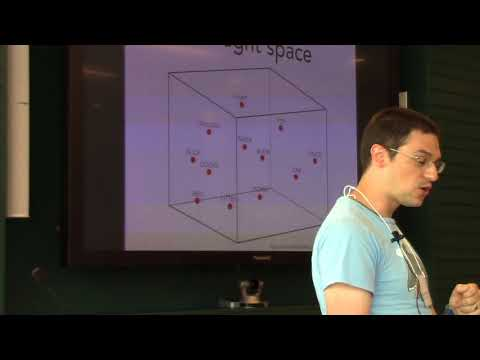

In [4]:
from IPython.display import YouTubeVideo

YouTubeVideo('hb_ER9RGtOM')

The **HyperTools data visualization pipeline** defines a set of heuristics for preprocessing a high-dimensional multi-subject dataset and generating a visualization that may be used to gain useful insights into the data.  The idea is to generate visualizable 2D and 3D shapes and animations that reflect key properties of the data.  For example, this visualization displays several participants' unfolding neural patterns as they listen to a 10-minute story (here each line represents the neural activity patterns of a single person):
![250px](https://hypertools.readthedocs.io/en/latest/_images/hypertools.gif)

The pipeline comprises the following steps:
1. Wrangle the dataset into a list of numerical matrices (*one matrix per subject*).  The matrices' *rows denote timepoints* and their *columns denote features* (a feature may be a voxel, electrode, a word embedding dimension, a label or category, or some other set of observable or quantifiable values).  Note that, for some data types, this wrangling process is non-trivial.  HyperTools incorporates useful functions for [parsing](https://hypertools.readthedocs.io/en/latest/hypertools.tools.format_data.html#hypertools.tools.format_data) a variety of datatypes, including text data.  The [pliers](https://github.com/tyarkoni/pliers) toolbox may also be used to generate HyperTools-compatable feature vectors for a wider range of datatypes.
2. Normalize (*z*-score) within each matrix column to ensure that all dimensions have equal representation in the final visualization.  (This step is optional.)  Pad matrices with columns of zeros as needed, to ensure they all have the same number of columns ($k$).  Note that all matrices must have the same number of rows (number of rows/timepoints: $t$).
3. [Hyperalign](http://haxbylab.dartmouth.edu/publications/HGC+11.pdf) the matrices into a common space.
4. [Embed](https://hypertools.readthedocs.io/en/latest/hypertools.reduce.html#hypertools.reduce) the hyperaligned data into a low-dimensional space (typically this space will be either 2D or 3D).
5. Generate a plot or animation of the reduced data.

If a dataset is stored in the list `data`, the HyperTools pipeline may be used to generate a visualization using a single command:
```
import hypertools as hyp
hyp.plot(data)
```

# Getting Started
Before getting started with this tutorial, we need to make sure you have the necessary software installed and data downloaded.

## Software
This tutorial requires the following Python packages to be installed. See the [Software Installation](http://naturalistic-data.org/features/notebooks/Software.html) tutorial for more information.

- hypertools
- timecorr
- seaborn
- matplotlib
- numpy
- pandas
- scipy
- nltools
- nilearn
- datalad

Let's now load the modules we will be using for this tutorial.

In [13]:
import os
from glob import glob as lsdir
import numpy as np
import pandas as pd
from scipy.interpolate import pchip
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data, Adjacency
from nilearn.plotting import plot_stat_map
import datalad.api as dl

import hypertools as hyp
import seaborn as sns
import timecorr as tc

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

## Data
This tutorial will be using the **Sherlock** dataset and will require downloading the cropped and denoised **hdf5** files.

You will want to change `datadir` to wherever you have installed the Sherlock datalad repository (e.g. `~/data`). We will initialize a datalad dataset instance and get the files we need for this tutorial. If you've already downloaded everything, you can skip this cell. See the [Download Data Tutorial](http://naturalistic-data.org/features/notebooks/Download_Data.html) for more information about how to install and use datalad.

In [15]:
datadir = '/Volumes/Engram/Data/Sherlock'

# If dataset hasn't been installed, clone from GIN repository
if not os.path.exists(datadir):
    dl.clone(source='https://gin.g-node.org/ljchang/Sherlock', path=datadir)

# Initialize dataset
ds = dl.Dataset(datadir)

# Get Cropped & Denoised CSV Files
result = ds.get(lsdir(os.path.join(datadir, 'fmriprep', '*', 'func', '*crop*hdf5')))

# ROI responses while viewing Sherlock

Following the [functional alignment tutorial](http://naturalistic-data.org/features/notebooks/Functional_Alignment.html), we'll select out voxels in early visual cortex from the *Sherlock* dataset.  We'll also examine primary auditory cortex and motor cortex responses.  Then we'll apply the HyperTools pipeline to the dataset and visualize the responses within each ROI as a 3D image. Note you could also work with the Average ROI csv files as we did with the Dynamic Correlation tutorial. Here, we will load the full dataset and manually extract ROIs.

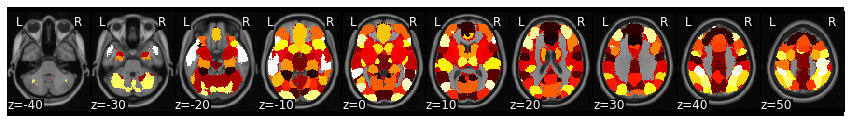

In [21]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
vectorized_mask = expand_mask(mask)
mask.plot()

In [16]:
rois = pd.read_csv('https://raw.githubusercontent.com/naturalistic-data-analysis/tutorial_development/master/hypertools/rois.csv', header=None, names=['ID', 'Region'])
rois.head()

,ID,Region
0,0,Anterior MPFC
1,1,Fusiform/parahippocampus
2,2,DMPFC
3,3,Sensorimotor/postcentral gyrus
4,4,V1


In [23]:
roi_names = ['V1', 'A1', 'Precentral gyrus']
roi_ids = [int(rois.query(f'Region == "{r}"')['ID']) for r in roi_names]
my_rois = {k:v for k, v in zip(roi_names, roi_ids)}

In [29]:
def extract_roi_data(fname_template, mask, roi_id):
    fnames = lsdir(fname_template)
    roi_data = []
    for f in fnames:
        print(f'extracting data for ROI {roi_id}: ' + f.split(os.path.sep)[-1][:40] + '...')
        roi_data.append(Brain_Data(f).apply_mask(mask[roi_id]))
    return roi_data

In [30]:
# define filename templates
sherlock_part1 = os.path.join(datadir, 'fmriprep', '*', 'func', '*crop*Part1*hdf5')
sherlock_part2 = os.path.join(datadir, 'fmriprep', '*', 'func', '*crop*Part2*hdf5')
parts = {'part 1': sherlock_part1, 'part 2': sherlock_part2}

In [31]:
data = {}
for p in parts.keys():
    roi_data = {}
    for r in my_rois.keys():
        roi_data[r] = extract_roi_data(parts[p], vectorized_mask, my_rois[r])
    data[p] = roi_data

extracting data for ROI 4: sub-01_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-02_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-03_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-04_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-05_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-06_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-07_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-08_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-09_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-10_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-11_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-12_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-13_denoise_crop_smooth6mm_task-sherl...
extracting data for ROI 4: sub-14_denoise_crop_smooth6mm_task-sherl...
extrac

In [27]:
data

{'part 1': {'V1': [], 'A1': [], 'Precentral gyrus': []},
 'part 2': {'V1': [], 'A1': [], 'Precentral gyrus': []}}

# Getting some intuitions for the Sherlock data using HyperTools

## Examining brain responses in visual, auditory, and motor cortex during movie watching

Participants in the Sherlock experiment all watched the same audiovisual movie.  Therefore, to the extent that participants' brain responses were driven by the movie, we might expect that their brain responses in primary auditory and visual cortex should follow similar or related patterns.  In contrast, non-sensory regions like primary motor cortex should not show this sort of agreement.

We can test this intuition qualitatively by projecting the ROI data from visual, auditory, and motor cortex into a shared low-dimensional space.  Each participant's trajectory will be plotted in a different color.  Regions that show greater agreement across participants will have more similarly shaped (overlapping) trajectories when plotted using the HyperTools pipeline.

In [10]:
def plot_aligned_ROI_trajectories(data, reduce='UMAP', align='hyper', n_iter=5, ndims=500, internal_reduce='IncrementalPCA', **kwargs):
    if type(data) == dict:
        for r in data.keys(): #roi
            plot_aligned_ROI_trajectories(data[r], reduce=reduce, align=align, ndims=ndims, internal_reduce=internal_reduce, title=r, **kwargs)
    else:
        #step 1: reduce dataset before aligning (runs much faster)
        reduced_data = hyp.reduce([x.data for x in data], reduce=internal_reduce, ndims=ndims)

        #step 2: smooth trajectories so they look prettier
        smoothed_data = tc.smooth(reduced_data, kernel_fun=tc.helpers.gaussian_weights, kernel_params={'var': 500})
        
        #step 3: align trajectories
        aligned_data = smoothed_data
        for i in range(n_iter):
            aligned_data = hyp.align(aligned_data, align=align)

        #now generate a plot
        hyp.plot(aligned_data, reduce=reduce, **kwargs)

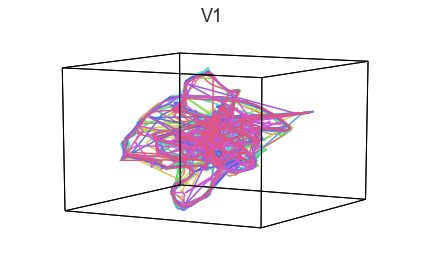

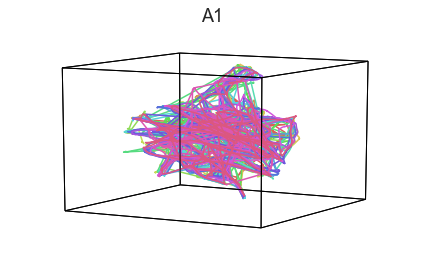

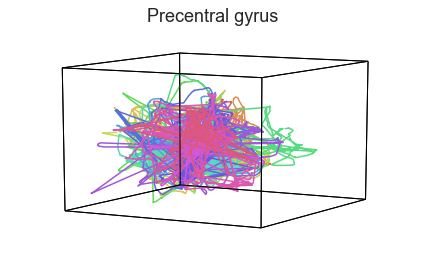

In [11]:
plot_aligned_ROI_trajectories(data['part 1'])

We can see strong agreement across people in V1 and A1, whereas precentral gyrus responses are much more variable.  Now let's see if these patterns also hold for the second half of the dataset:

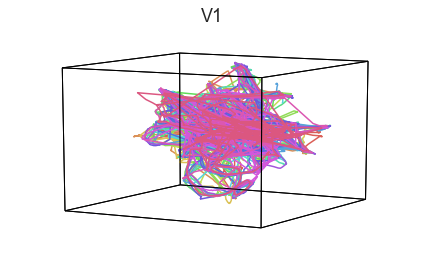

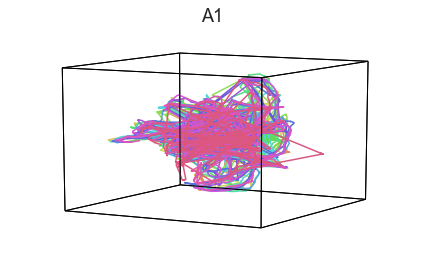

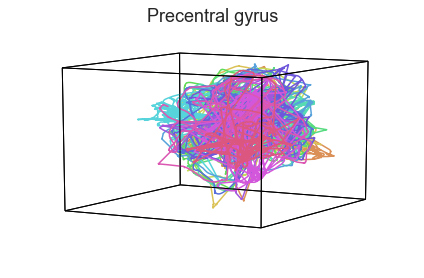

In [12]:
plot_aligned_ROI_trajectories(data['part 2'])

It looks like this pattern holds!  To test this idea formally, we could develop a measure of trajectory consistency across people (e.g. mean squared error between the corresponding timepoints, across all pairs of participants' trajectories).  We could also explore the extent to which different brain regions exhibit consistent patterns across people.

### Using different embedding spaces to obtain a more complete sense of high-dimensional space
When we visualize high-dimensional data as 3D shapes, we necessarily lose information.  One strategy for getting a better sense of the "true shape" of the data is to use different projection algorithms for embedding the data into the 3D space (this may be done using the `reduce` keyword).

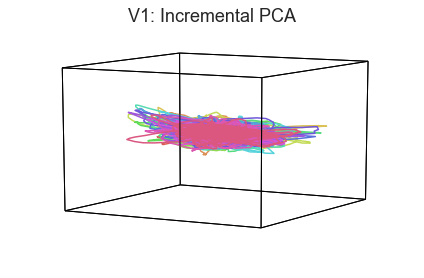

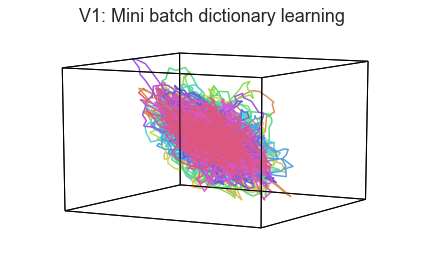

In [13]:
first_roi = list(data['part 1'].keys())[0]
plot_aligned_ROI_trajectories(data['part 1'][first_roi], align='hyper', reduce='IncrementalPCA', title=f'{first_roi}: Incremental PCA')
plot_aligned_ROI_trajectories(data['part 1'][first_roi], align='hyper', reduce='MiniBatchDictionaryLearning', title=f'{first_roi}: Mini batch dictionary learning')

In both of these examples we can still see the high degree of consistency across people.  Each embedding approach amplifies preserves or emphasizes a different set of properties from the original high-dimensional feature space.

### Aligning using the shared response model

The above examples use hyperalignment to map different participants' data into a common space.  HyperTools also supports alignment using the [Shared Response Model (SRM)](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model):

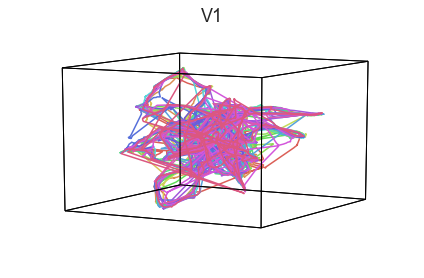

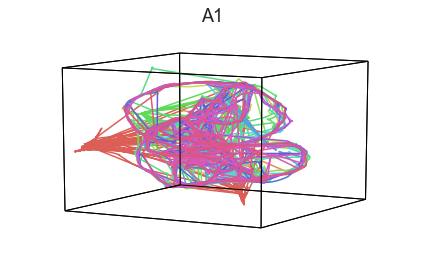

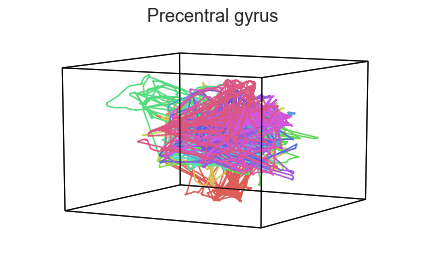

In [14]:
plot_aligned_ROI_trajectories(data['part 1'], align='SRM')

## What is the "shape" of the Sherlock episode?

Following an approach similar to the one used in [Heusser et al., 2018](https://www.biorxiv.org/content/10.1101/409987v1), we can use also HyperTools to examine how the content of the Sherlock episode unfolds.  Whereas the analyses above show how HyperTools may be used to gain insight into dynamics in neural data, we can also use HyperTools to examine how the semantic content of the episode changes over time.  We'll fit a word embedding model to a set of detailed annotations of each scene in the episode.

First, let's download the annotations to get a sense of what they're like.

In [6]:
def download(source, dest):
    if not os.path.exists(dest):
        stream = urllib.request.urlopen(source)
        data = stream.read()

        with open(dest, 'wb') as fd:
            fd.write(data)

In [7]:
# raw annotations
annotations_source = 'https://github.com/ContextLab/sherlock-topic-model-paper/raw/revision-1/data/raw/Sherlock_Segments_1000_NN_2017.xlsx'
annotations_dest = os.path.join(datadir, 'Sherlock', 'stimuli', 'annotations.xlsx')
download(annotations_source, annotations_dest)
annotations = pd.read_excel(annotations_dest)
annotations.head(3)

NameError: name 'os' is not defined

Next, we'll preprocess the anotations in sliding windows of (up to) 50 segments.  In each sliding window, we'll concatenate all of the text into a single "blob" that merges all of the columns of the annotation spreadsheet, from all of the segments in that window.  Note that the preprocessing was carried out using the code in [this notebook](https://github.com/ContextLab/sherlock-topic-model-paper/blob/revision-1/code/notebooks/main/topic_model_analysis.ipynb); here we'll be downloading the resulting preprocessed text rather than reproducing it.

In [31]:
# preprocessed annotations
preprocessed_source = 'https://github.com/ContextLab/sherlock-topic-model-paper/raw/revision-1/data/processed/video_text.npy'
preprocessed_dest = os.path.join(datadir, 'Sherlock', 'stimuli', 'video_text.npy')
download(preprocessed_source, preprocessed_dest)

text = np.load(preprocessed_dest)

Let's examine the text in a window somewhere near the middle:

In [32]:
text[500][:250] + '...'

'sherlock takes a deep breath through his nose outdoor sherlock donovan sherlock lauriston gardens  street  over the shoulder medium no sherlock i even know you didnt make it home last night outdoor sherlock donovan sherlock sherlock lauriston gardens...'

Next, we'll use HyperTools to train a topic model ([Blei et al., 2003](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)) on the annotations, treating the text in each sliding window as a document.  We'll plot the result as a 3D shape.  (For an example of an alternative word embedding model, see the [Natural Language Processing tutorial](http://naturalistic-data.org/features/notebooks/Natural_Language_Processing.html).)

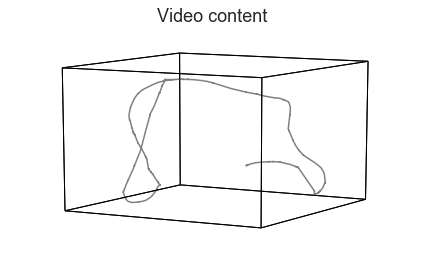

In [33]:
text_geometry = hyp.plot(text, reduce='UMAP', color='gray', title='Video content')

We can also visualize the timecourse of word embeddings for the movie as a heatmap.  Since we've already fit our topic model to the annotation text, HyperTools automatically uses the cached result (so the command runs quickly).  Here each row is a timepoint and each column is a topic dimension (i.e., a word embedding dimension):

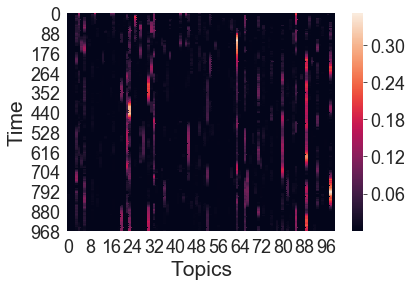

In [34]:
topics = text_geometry.get_formatted_data()[0]
h = sns.heatmap(topics)
h.set_xlabel('Topics');
h.set_ylabel('Time');

# Further reading

For more in-depth explorations of the Sherlock data using HyperTools, check out [this paper](https://www.biorxiv.org/content/10.1101/409987v1) along with the associated [code and data](https://github.com/ContextLab/sherlock-topic-model-paper).  For more in-depth HyperTools tutorials, take a look [here](https://hypertools.readthedocs.io/en/latest/tutorials.html).  [This repository](https://github.com/ContextLab/hypertools-paper-notebooks) contains additional example applications of HyperTools to a variety of different data types.